In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [26]:
data=pd.read_csv(f'future-gc00-daily-prices.csv')

In [27]:
data.info


<bound method DataFrame.info of             Date      Open      High       Low     Close
0     01/02/2013  1,676.40  1,695.40  1,670.90  1,688.80
1     01/02/2014  1,204.50  1,230.80  1,202.50  1,225.20
2     01/02/2015  1,184.00  1,194.90  1,167.30  1,186.20
3     01/02/2018  1,305.30  1,320.40  1,304.60  1,316.10
4     01/02/2019  1,285.00  1,291.00  1,280.60  1,284.10
...          ...       ...       ...       ...       ...
3719  12/31/2015  1,060.60  1,062.70  1,056.50  1,060.20
3720  12/31/2018  1,283.00  1,286.50  1,279.70  1,281.30
3721  12/31/2019  1,517.70  1,529.00  1,517.50  1,523.10
3722  12/31/2020  1,899.00  1,904.90  1,889.10  1,895.10
3723  12/31/2021  1,817.00  1,831.40  1,815.40  1,828.60

[3724 rows x 5 columns]>

In [28]:
data.isna()

,Date,Open,High,Low,Close
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
3719,False,False,False,False,False
3720,False,False,False,False,False
3721,False,False,False,False,False
3722,False,False,False,False,False


In [29]:
data.isna().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

In [30]:
data.isna().sum().sum()

0

In [31]:
data.head()

,Date,Open,High,Low,Close
0,01/02/2013,"1,676.40","1,695.40","1,670.90","1,688.80"
1,01/02/2014,"1,204.50","1,230.80","1,202.50","1,225.20"
2,01/02/2015,"1,184.00","1,194.90","1,167.30","1,186.20"
3,01/02/2018,"1,305.30","1,320.40","1,304.60","1,316.10"
4,01/02/2019,"1,285.00","1,291.00","1,280.60","1,284.10"


In [32]:
data.head(10)

,Date,Open,High,Low,Close
0,01/02/2013,"1,676.40","1,695.40","1,670.90","1,688.80"
1,01/02/2014,"1,204.50","1,230.80","1,202.50","1,225.20"
2,01/02/2015,"1,184.00","1,194.90","1,167.30","1,186.20"
3,01/02/2018,"1,305.30","1,320.40","1,304.60","1,316.10"
4,01/02/2019,"1,285.00","1,291.00","1,280.60","1,284.10"
5,01/02/2020,"1,521.00","1,534.00","1,519.70","1,528.10"
6,01/02/2024,"2,072.70","2,088.10","2,064.30","2,073.40"
7,01/03/2011,"1,420.40","1,424.40","1,413.10","1,422.90"
8,01/03/2012,"1,571.00","1,608.70","1,566.80","1,600.50"
9,01/03/2013,"1,686.20","1,690.50","1,661.20","1,674.60"


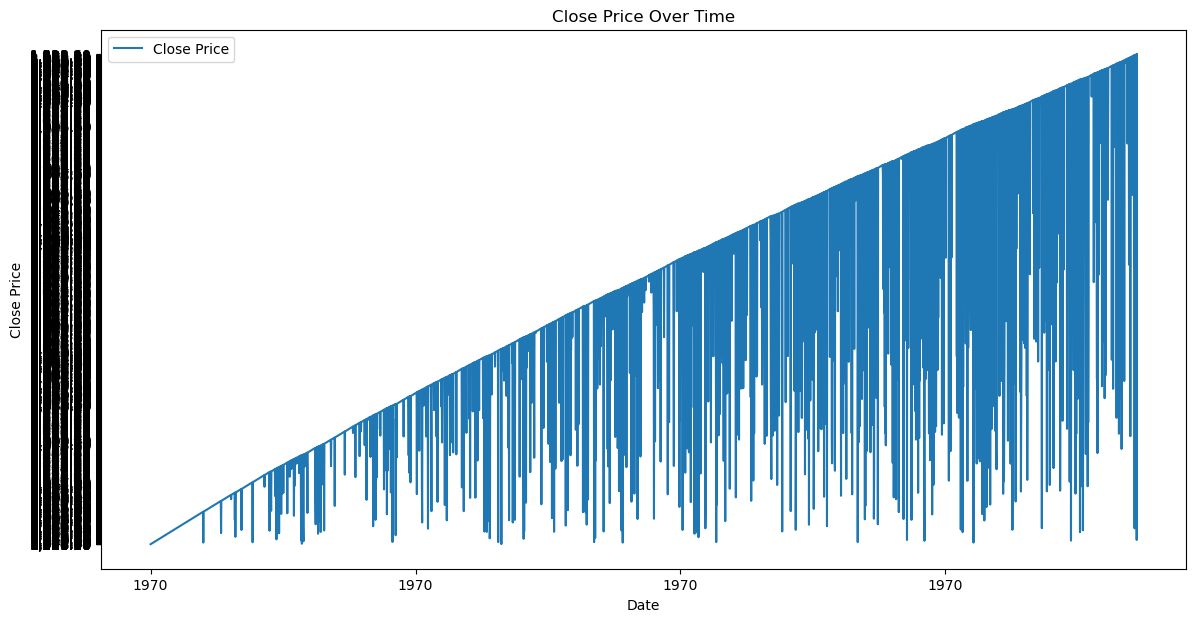

In [33]:
# data.index = pd.to_datetime(data.index)
plt.figure(figsize=(14,7))
# data.index = pd.to_datetime(data.index)
plt.plot(pd.to_datetime(data.index), data['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [38]:
# Remove commas and convert to numeric
data['Close'] = data['Close'].replace({',': ''}, regex=True).astype(float)
# Now perform the ADF test
from statsmodels.tsa.stattools import adfuller
result_original = adfuller(data['Close'])
print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")
data['Close'] = data['Close'].replace({',': ''}, regex=True).astype(float)

ADF Statistic (Original): -11.4984
p-value (Original): 0.0000


Interpretation: The original series is Stationary.

ADF Statistic (Differenced): -15.5835
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


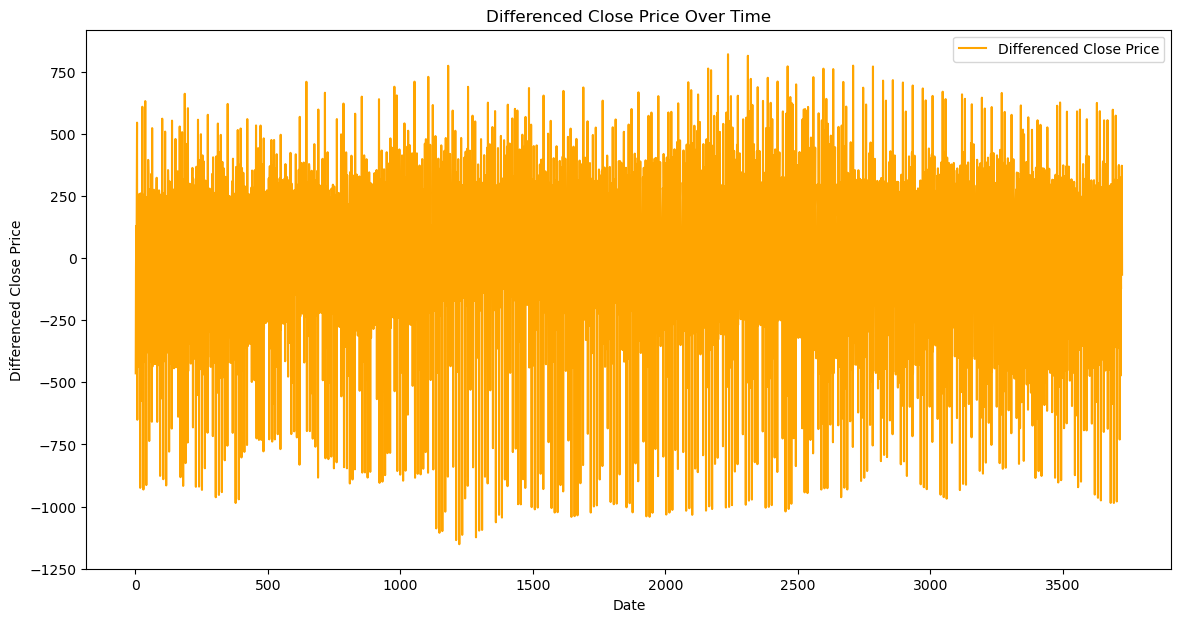

In [43]:
# Interpretation for the original series
if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.")
else:
    print("Interpretation: The original series is Non-Stationary.")

# Differencing the series to make it stationary
data['Close_Diff'] = data['Close'].diff().dropna()

# Perform ADF test on the differenced series
result_diff = adfuller(data['Close_Diff'].dropna())
print(f"\nADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")

# Interpretation for the differenced series
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

# Plotting the differenced series
plt.figure(figsize=(14, 7))
plt.plot(data.index[1:], data['Close_Diff'].dropna(), label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

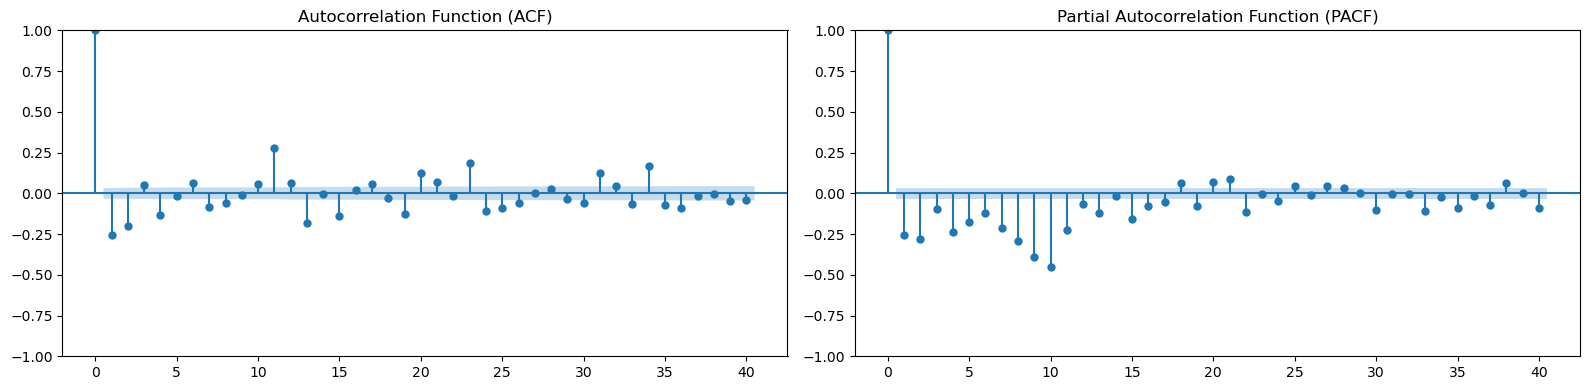

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()


In [45]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["Close"], order=(1,1,1))
model_fit = model.fit()


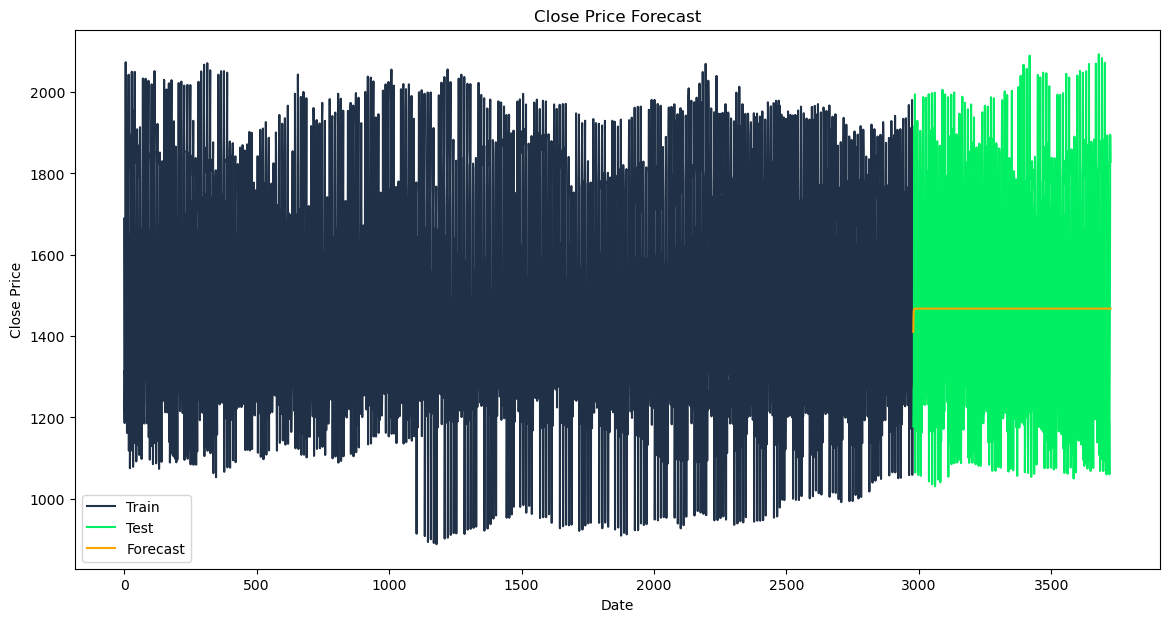

In [47]:
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [48]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")


AIC: 41983.766754498676
BIC: 42001.76377613841


In [49]:
forecast = forecast[:len(test)]
test_close = test["Close"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")


RMSE: 298.6249
